# Century DCIP Inversion with a Triangular Mesh

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/pygimli_dcip/pygimli_dcip_century_tri_mesh.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## Motivation

The Century Deposit is a zinc-lead-silver deposit in the Mt Isa region in Queensland Australia and UBC 2D DCIP inversion results have been published by [Mutton, 2000](https://doi.org/10.1190/1.1444878) and reproduced with [SimPEG](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs). It provides an excellent test case to verify if CoFI can indeed act as a glue between forward solvers and inverse solvers and be applied to real data. [Figure 1](https://github.com/inlab-geo/cofi-examples/blob/main/examples/pygimli_dcip/Mutton-Figure1-1.png?raw=true) from [Mutton, 2000](https://doi.org/10.1190/1.1444878) provides a map of the location and geological setting for the Century deposit.

<img src="https://github.com/inlab-geo/cofi-examples/blob/main/data/century_dcip/Mutton-Figure1-1.png?raw=true" width=40%> 

A detailed descrtiption of the geological setting is available [here](http://portergeo.com.au/database/mineinfo.asp?mineid=mn075) and [Mutton, 2000](https://doi.org/10.1190/1.1444878) also provide the [cross-section](https://github.com/inlab-geo/cofi-examples/blob/main/examples/pygimli_dcip/Mutton-Figure2-1.png?raw=true) for the survey line 46800mE, which we will invert in the following.

<img src="https://github.com/inlab-geo/cofi-examples/blob/main/data/century_dcip/Mutton-Figure2-1.png?raw=true" width=50%>

What we are interested in is delineating the mineralised units by using the DCIP (Direct Current, Induced Polarization) solver implemented in [PyGIMLi](https://www.pygimli.org/) together with the `cofi` solvers. 

Some background information around how a DCIP inversion using complex numbers to express resistivity and chargeability can be implemented using CoFI is given in [the synthetic example notebook](pygimli_dcip.ipynb). While PyGIMLi allows us to use a triangular mesh which can be adanvatengous when compared with a rectilinear mesh, it also requires the data and model to be expressed as frequency domain measurements, that is as complex numbers where the real part represents the resistivity and the phase angle the chargeability. There are several ways to [capture/express chargeability](https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html) and SimPEG uses apparent chargeabilities $\mathrm{M}$. Thus prior to inversion we will convert them using the following rule of thumb $0.1 M \approx70 \mathrm{mrad}$.


#### References

Martin, T., Günther, T., Orozco, A. F., & Dahlin, T. (2020). Evaluation of spectral induced polarization field measurements in time and frequency domain. Journal of Applied Geophysics, 180. https://doi.org/10.1016/j.jappgeo.2020.104141

Mutton, A. J. (2000). The application of geophysics during evaluation of the Century zinc deposit. Geophysics, 65(6), 1946–1960. https://doi.org/10.1190/1.1444878


## Table of contents

1. [Set up environment](#setup)
2. [Load the data](#load)
3. [Utility wrappers to PyGIMLi functions](#utility)
    1. [Helper functions for complex numbers](#complex)
    2. [Helper functions for PyGIMLi modelling](#modelling)
    3. [Plotting utilities](#plotting)
4. [PyGIMLi problem setup](#pygimli)
    1. [Data container](#container)
    2. [ERT manager](#ertmanager)
    3. [Inversion mesh](#invmesh)
    4. [Forward operator](#fop)
    5. [Regularization matrix](#regmat)
    6. [Starting model](#nullmodel)
5. [Create utility functions to pass to CoFI](#utility2)
6. [Define the inversion options and run](#run)
    1. [Comparison with published results](#comparison)

## 1. Set up environment <a name="setup"></a>

We'll do the following:
1. Install PyGIMLi (if on CoLab)
2. Download processed dataset (if on CoLab)
3. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi pygimli tetgen

In [2]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/pygimli_dcip

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygimli
import cofi

## 2. Load the data <a name="load"></a>

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [4]:
data_base_path = "../../data/century_dcip"
dcip_data = np.loadtxt(f"{data_base_path}/century_dcip_data.txt")

### Converting measurements of chargeability

PyGIMLi expresses chargeability in $\mathrm{radians}$ and we convert the apparent chargeabilites as we load the data.

In [5]:
a_locs = dcip_data[:,0]
b_locs = dcip_data[:,1]
m_locs = dcip_data[:,2]
n_locs = dcip_data[:,3]
dc_obs = dcip_data[:,4]
dc_err = dcip_data[:,5]
ip_obs = dcip_data[:,6]*0.7   # https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
ip_err = dcip_data[:,7]*0.7
geo_factors = dcip_data[:,8]

location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

In [6]:
def load_leapfrog_geologic_section(filename=f"{data_base_path}/century_geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

geologic_section = load_leapfrog_geologic_section()

## 3. Utility wrappers to PyGIMLi functions <a name="utility"></a>

Below we define a set of utility functions that help define the problem, generating data and making plots. Feel free to skip reading the details of these utility functions and come back later if you want.

### 3.1. Helper functions for complex numbers <a name="complex"></a>

In [7]:
def rho_phi_to_complex(rho, phi):      # rho * e^(phi * i)
    return pygimli.utils.toComplex(rho, phi)

def rho_phi_from_complex(complx):      # |complx|, arctan(complx.imag, complx.real)
    return np.abs(complx), np.arctan2(complx.imag, complx.real)

def complex_to_real(complx):           # complx vector of size n -> size 2n
    return pygimli.utils.squeezeComplex(complx)

def complex_from_real(real):           # real vector of size n -> size n/2
    return pygimli.utils.toComplex(real)

### 3.2. Helper functions for PyGIMLi modelling <a name="modelling"></a>

In [8]:
# inversion mesh bound
x_inv_start = location_start - 200
x_inv_stop = location_stop + 200
y_inv_start = -400
y_inv_stop = 0

# PyGIMLi DataContainerERT
def pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err):
    # --- create empty data container object ---
    pg_data = pygimli.DataContainerERT()
    # create sensor locations
    for sensor in np.linspace(location_start, location_stop, location_num):
        pg_data.createSensor((sensor, 0.0, 0.0))
    # --- add indices for data points ---
    locs_sources = np.vstack((a_locs, b_locs)).T
    locs_receivers = np.vstack((m_locs, n_locs)).T
    for i in range(len(locs_sources)):
        src = locs_sources[i]
        src_idx = (src - location_start) / location_interval
        rec = locs_receivers[i]
        rec_idx = (rec - location_start) / location_interval
        pg_data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
    # --- fill in the observed data and error estimation ---
    pg_data["rhoa"] = dc_obs
    pg_data["err"] = dc_err
    pg_data["phia"] = -ip_obs/1000.  # PyGIMLi accepts radians (instead of milliradians) for forward modelling
    pg_data["iperr"] = ip_err/1000.
    # --- create geometric factor k ---
    pg_data["k"] = pygimli.physics.ert.createGeometricFactors(pg_data, numerical=True)
    # --- generate data vals and diag vals of covariance inv matrix in log complex space ---
    data_complex = rho_phi_to_complex(pg_data["rhoa"].array(), pg_data["phia"].array())
    data_log_complex = np.log(data_complex)
    dc_err_log = np.log(pg_data["err"])
    ip_err_log = np.log(pg_data["iperr"])
    m_err = rho_phi_to_complex(1/dc_err_log, 1/ip_err_log)
    Wd = np.diag(m_err)
    Cd_inv = Wd.conj().dot(Wd)
    return pg_data, data_log_complex, Cd_inv

# PyGIMLi ert.ERTManager
def ert_manager(pg_data, verbose=False):
    return pygimli.physics.ert.ERTManager(pg_data, verbose=verbose, useBert=True)

# mesh used for inversion
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    inv_mesh = inv_mesh.createH2()
    ert_mgr.setMesh(inv_mesh)
    print("model size", ert_mgr.paraDomain.cellCount())
    return inv_mesh

# mesh used for the original paper
def inversion_mesh_ubc(ert_mgr):
    mesh_ubc = pygimli.meshtools.readMeshIO(f"{data_base_path}/century_mesh.vtk")
    print("model size", mesh_ubc.cellCount())
    ert_mgr.setMesh(mesh_ubc)
    return mesh_ubc

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_mgr, pg_data, inv_mesh):
    forward_oprt = ert_mgr.fop
    forward_oprt.setComplex(True)
    forward_oprt.setData(pg_data)
    forward_oprt.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_oprt

# regularization matrix
def reg_matrix(forward_oprt, inv_mesh):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    region_manager.setMesh(inv_mesh)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

def starting_model(data, inv_mesh, rho_val=None, phi_val=None):
    rho_start = np.median(data["rhoa"]) if rho_val is None else rho_val
    phi_start = np.median(data["phia"]) if phi_val is None else phi_val
    start_model_val = rho_phi_to_complex(rho_start, phi_start)
    start_model_complex = np.ones(inv_mesh.cellCount()) * start_model_val
    start_model_log_complex = np.log(start_model_complex)
    start_model_log_real = complex_to_real(start_model_log_complex)
    return start_model_complex, start_model_log_complex, start_model_log_real

def reference_dc_model():
    return np.loadtxt(f"{data_base_path}/century_dc_model.txt")

def reference_ip_model():
    return -np.loadtxt(f"{data_base_path}/century_ip_model.txt") * 0.7 / 1000

# initialise model to have same resistivities as the original inversion result
def starting_model_ref(ert_mgr):
    dc_model_ref = np.loadtxt(f"{data_base_path}/century_dc_model.txt")
    assert ert_mgr.paraDomain.cellCount() == len(dc_model_ref), \
        "mesh cell count has to match century reference model length"
    return starting_model(ert_mgr, rhoa_val=dc_model_ref)

### 3.3. Plotting utilities <a name="plotting"></a>

Note: We lifted out the plotting of colorbars only for Colab compatibility.

In [9]:
resistivity_label = r"$\Omega m$"
chargeability_label = r"mrad"

def plot_geologic_section(geologic_section, ax):
    for data in geologic_section:
        ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)

def plot_colorbar(ax, cMin, cMax, label, orientation="horizontal"):
    norm = mpl.colors.Normalize(cMin, cMax)
    sm = plt.cm.ScalarMappable(norm=norm)
    cb = plt.colorbar(sm, orientation=orientation, ax=ax)
    cb.set_label(label)
    cb.set_ticks(np.linspace(cMin, cMax, 5, endpoint=True))

def plot_model(mesh, model_complex, title):
    rho, phi = rho_phi_from_complex(model_complex)
    fig, axes = plt.subplots(2,1,figsize=(12,5))
    pygimli.show(mesh, data=rho, label=resistivity_label, ax=axes[0], colorBar=False)
    axes[0].set_xlim(x_inv_start, x_inv_stop)
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title("Resistivity")
    plot_colorbar(axes[0], 136, 170, resistivity_label)
    pygimli.show(mesh, data=phi * 1000, label=chargeability_label, cMin=-4.76, cMax=-4, ax=axes[1], colorBar=False)
    axes[1].set_xlim(x_inv_start, x_inv_stop)
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title("Chargeability")
    plot_colorbar(axes[1], -4.76, -4, chargeability_label)
    if title != "Starting model":
        plot_geologic_section(geologic_section, axes[0])
        plot_geologic_section(geologic_section, axes[1])
    fig.suptitle(title)

def plot_data(pg_data, data_complex, title):
    rho, phi = rho_phi_from_complex(data_complex)
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    # pygimli.physics.ert.showERTData(pg_data, vals=rho, label=resistivity_label, ax=axes[0], colorBar=False)
    pygimli.physics.ert.showERTData(pg_data, vals=rho, ax=axes[0], colorBar=False)
    axes[0].set_title("Apparent Resistivity")
    plot_colorbar(axes[0], np.min(rho), np.max(rho), resistivity_label)
    pygimli.physics.ert.showERTData(pg_data, vals=phi*1000, ax=axes[1], colorBar=False)
    # pygimli.physics.ert.showERTData(pg_data, vals=phi*1000, label=chargeability_label, ax=axes[1], colorBar=False)
    axes[1].set_title("Apparent Chargeability")
    plot_colorbar(axes[1], np.min(phi*1000), np.max(phi*1000), chargeability_label)
    fig.suptitle(title)

def plot_mesh(mesh, title="Mesh used for inversion"):
    _, ax = plt.subplots(1, 1)
    pygimli.show(mesh, showMesh=True, markers=False, colorBar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("Elevation (m)")

def plot_comparison(mesh1, model1, title1, mesh2, model2, title2, rho_min, rho_max, phi_min, phi_max):
    rho1, phi1 = rho_phi_from_complex(model1)
    rho2, phi2 = rho_phi_from_complex(model2)
    fig, axes = plt.subplots(4, 1, figsize=(10,12))
    pygimli.show(mesh1, data=rho1, label=resistivity_label, ax=axes[0], colorBar=False)
    axes[0].set_xlim(x_inv_start, x_inv_stop)
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title(f"{title1} - Resistivity")
    plot_colorbar(axes[0], rho_min, rho_max, resistivity_label)
    plot_geologic_section(geologic_section, axes[0])
    pygimli.show(mesh2, data=rho2, label=resistivity_label, ax=axes[1], cMin=rho_min, cMax=rho_max, colorBar=False)
    axes[1].set_xlim(x_inv_start, x_inv_stop)
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title(f"{title2} - Resistivity")
    plot_colorbar(axes[1], rho_min, rho_max, resistivity_label)
    plot_geologic_section(geologic_section, axes[1])
    pygimli.show(mesh1, data=phi1 * 1000, label=chargeability_label, ax=axes[2], colorBar=False)
    axes[2].set_xlim(x_inv_start, x_inv_stop)
    axes[2].set_ylim(y_inv_start, y_inv_stop)
    axes[2].set_title(f"{title1} - Chargeability")
    plot_colorbar(axes[2], phi_min*1000, phi_max*1000, chargeability_label)
    plot_geologic_section(geologic_section, axes[2])
    pygimli.show(mesh2, data=phi2 * 1000, label=chargeability_label, ax=axes[3], cMin=phi_min*1000, cMax=phi_max*1000, colorBar=False)
    axes[3].set_xlim(x_inv_start, x_inv_stop)
    axes[3].set_ylim(y_inv_start, y_inv_stop)
    axes[3].set_title(f"{title2} - Chargeability")
    plot_colorbar(axes[3], phi_min*1000, phi_max*1000, chargeability_label)
    plot_geologic_section(geologic_section, axes[3])

## 4. PyGIMLi problem setup <a name="pygimli"></a>

### 4.1. Data container <a name="container"></a>

In [10]:
pg_data, data_log_complex, Cd_inv = pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err)
pg_data

07/05/24 - 16:19:44 - pyGIMLi - INFO - Create default mesh for geometric factor calculation.
07/05/24 - 16:19:45 - pyGIMLi - INFO - Save RVector binary
07/05/24 - 16:19:45 - pyGIMLi - INFO - Cache stored: /home/jiawen/.cache/pygimli/7783406155969555268


ModellingBase::setMesh() copying new mesh ... Found datafile: 33 electrodes
Found: 33 node-electrodes
rMin = 50, rMax = 6400
NGauLeg + NGauLag for inverse Fouriertransformation: 12 + 4
Found non-Neumann domain
0.00529767 s
FOP updating mesh dependencies ... 2.028e-06 s
Forward: time: 0.970107s


Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'err', 'iperr', 'k', 'm', 'n', 'phia', 'rhoa', 'valid']

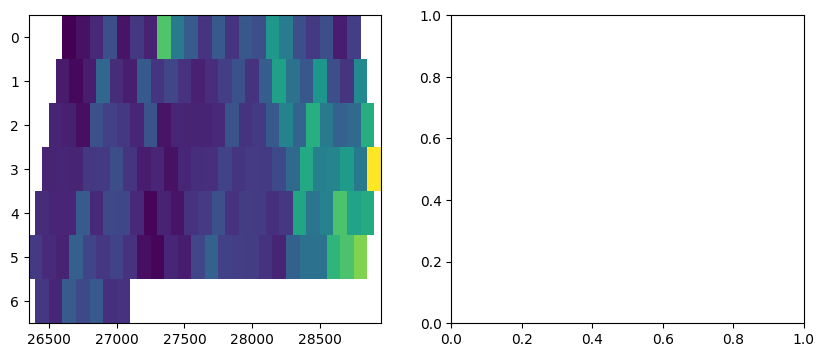

<Figure size 640x480 with 0 Axes>

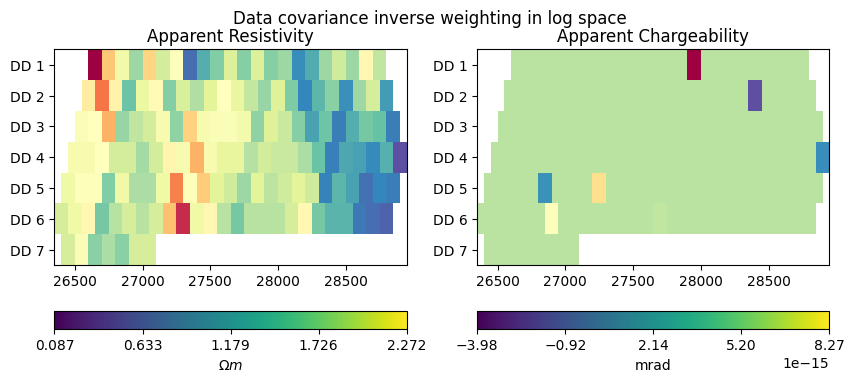

In [11]:
# this cell needs to be run twice in order to work well
plot_data(pg_data, np.exp(data_log_complex), "Data Observatons")
plot_data(pg_data, np.diag(Cd_inv), "Data covariance inverse weighting in log space")

### 4.2. ERT manager <a name="ertmanager"></a>

In [12]:
ert_mgr = ert_manager(pg_data)

### 4.3. Inversion mesh <a name="invmesh"></a>

07/05/24 - 16:19:46 - pyGIMLi - INFO - Found 2 regions.
07/05/24 - 16:19:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/05/24 - 16:19:46 - pyGIMLi - INFO - Found 2 regions.
07/05/24 - 16:19:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/05/24 - 16:19:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/05/24 - 16:19:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/05/24 - 16:19:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5657 Cells: 10912 Boundaries: 8384


model size 1912


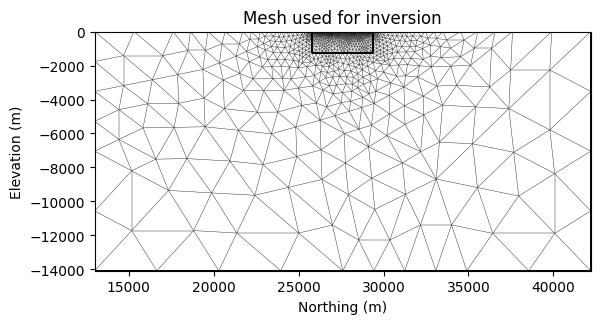

17/04/24 - 09:47:10 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5657 Cells: 10912 Boundaries: 8384


model size 1912


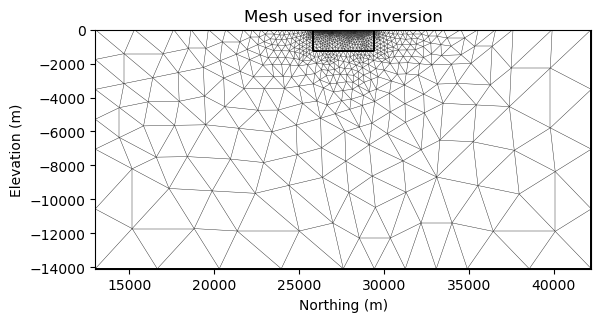

In [13]:
inv_mesh = inversion_mesh(ert_mgr)
# inv_mesh = inversion_mesh_ubc(ert_mgr)

plot_mesh(inv_mesh)

### 4.4. Forward operator <a name="fop"></a>

In [14]:
forward_oprt = ert_forward_operator(ert_mgr, pg_data, ert_mgr.paraDomain)

### 4.5. Regularization matrix <a name="regmat"></a>

In [15]:
Wm = reg_matrix(forward_oprt, ert_mgr.paraDomain)

07/05/24 - 16:19:46 - Core - INFO - More than 50 regions, so we assume single regions only.
07/05/24 - 16:19:46 - Core - INFO - Applying *:* interregion constraints.


### 4.6. Starting model <a name="nullmodel"></a>

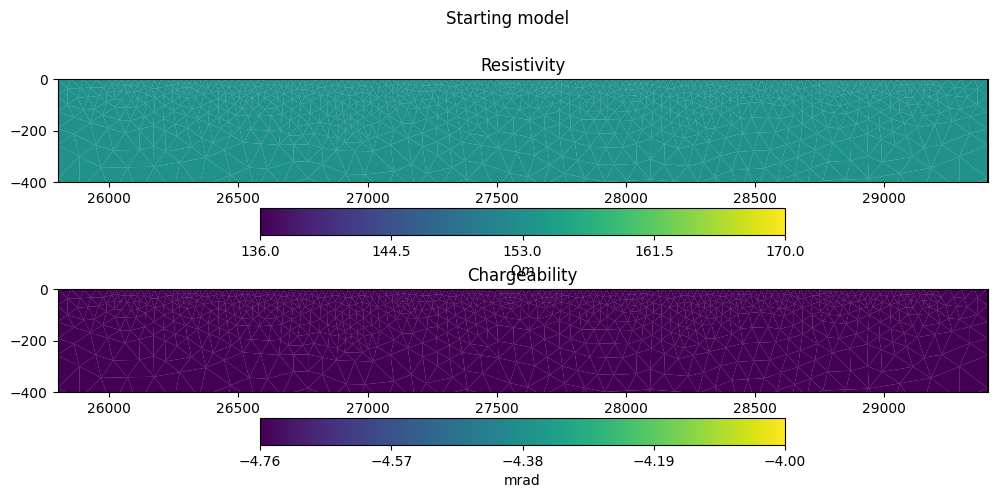

In [16]:
start_model_complex, start_model_log_complex, start_model_log_real = starting_model(pg_data, ert_mgr.paraDomain)

plot_model(ert_mgr.paraDomain, start_model_complex, "Starting model")

## 5. Create utility functions to pass to CoFI <a name="utility"></a>

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined below as additional utility functions, so feel free to read them into details if you want to understand more. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularization`
- `get_gradient`
- `get_hessian`

In [17]:
# Utility Functions (additional)

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

# model_log_complex -> data_log_complex
def get_response(model_log_complex, fop):
    model_complex = np.exp(model_log_complex)
    model_real = complex_to_real(model_complex)
    model_real = _ensure_numpy(model_real)
    data_real = np.array(fop.response(model_real))
    data_complex = complex_from_real(data_real)
    data_log_complex = np.log(data_complex)
    return data_log_complex

# model_log_complex -> J_log_log_complex
def get_jacobian(model_log_complex, fop):
    model_complex = np.exp(model_log_complex)
    model_real = complex_to_real(model_complex)
    model_real = _ensure_numpy(model_real)
    J_block = fop.createJacobian(model_real)
    J_real = np.array(J_block.mat(0))
    J_imag = np.array(J_block.mat(1))
    J_complex = J_real + 1j * J_imag
    data_log_complex = get_response(model_log_complex, fop)
    data_complex = np.exp(data_log_complex)
    J_log_log_complex = J_complex / data_complex[:,np.newaxis] * model_complex[np.newaxis,:]
    return J_log_log_complex

# model_log_complex -> res_data_log_complex
def get_residuals(model_log_complex, data_log_complex, fop):
    synth_data_log_complex = get_response(model_log_complex, fop)
    return data_log_complex - synth_data_log_complex

# model_log_real -> obj_log_real
def get_objective(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate data misfit
    res_log_complex = get_residuals(model_log_complex, data_log_complex, fop)
    data_misfit = res_log_complex.conj().dot(Cd_inv).dot(res_log_complex)
    # calculate regularization term
    weighted_model_log_real = Wm.dot(model_log_complex)
    reg = lamda * weighted_model_log_real.conj().dot(weighted_model_log_real)
    # sum up
    print(f"data misfit: {np.abs(data_misfit)}, reg: {np.abs(reg)}")
    result = np.abs(data_misfit + reg)
    return result

# model_log_real -> grad_log_real
def get_gradient(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate gradient for data misfit
    res = get_residuals(model_log_complex, data_log_complex, fop)
    jac = get_jacobian(model_log_complex, fop)
    data_misfit_grad = - jac.conj().T.dot(Cd_inv).dot(res)
    # calculate gradient for regularization term
    reg_grad = lamda * Wm.T.dot(Wm).dot(model_log_complex)
    # sum up
    grad_complex = data_misfit_grad + reg_grad
    grad_real = complex_to_real(grad_complex)
    return grad_real

# model_log_real -> hess_log_real
def get_hessian(model_log_real, data_log_complex, fop, lamda, Wm, Cd_inv):
    # convert model_log_real into complex numbers
    model_log_complex = complex_from_real(model_log_real)
    # calculate hessian for data misfit
    res = get_residuals(model_log_complex, data_log_complex, fop)
    jac = get_jacobian(model_log_complex, fop)
    data_misfit_hessian = jac.conj().T.dot(Cd_inv).dot(jac)
    # calculate hessian for regularization term
    reg_hessian = lamda * Wm.T.dot(Wm)
    # sum up
    hessian_complex = data_misfit_hessian + reg_hessian
    nparams = len(model_log_complex)
    hessian_real = np.zeros((2*nparams, 2*nparams))
    hessian_real[:nparams,:nparams] = np.real(hessian_complex)
    hessian_real[:nparams,nparams:] = -np.imag(hessian_complex)
    hessian_real[nparams:,:nparams] = np.imag(hessian_complex)
    hessian_real[nparams:,nparams:] = np.real(hessian_complex)
    return hessian_real

In [18]:
# test
try:
    get_response(start_model_log_real, forward_oprt)
except RuntimeError:
    print("run again")
    get_response(start_model_log_real, forward_oprt)

run again


In [19]:
# test
obj_val = get_objective(start_model_log_real, data_log_complex, forward_oprt, 0.0001, Wm, Cd_inv)
obj_val

data misfit: 16.48522124408904, reg: 0.0


16.48522124408904

In [20]:
# test
gradient = get_gradient(start_model_log_real, data_log_complex, forward_oprt, 0.0001, Wm, Cd_inv)
gradient.shape, gradient

((3824,), 3824 [-0.033030604267734374,...,-9.278041138103444e-06])

In [21]:
# test
hessian = get_hessian(start_model_log_real, data_log_complex, forward_oprt, 0.0001, Wm, Cd_inv)
hessian.shape, hessian

((3824, 3824),
 array([[ 5.38948398e-03,  2.13205609e-03,  2.52937620e-03, ...,
         -1.78203260e-17, -3.37289565e-17, -1.56101689e-17],
        [ 2.13205609e-03,  1.52260555e-03,  1.36485591e-03, ...,
         -1.17710883e-17, -1.83323300e-17, -9.48221617e-18],
        [ 2.52937620e-03,  1.36485591e-03,  2.07533134e-03, ...,
         -1.90750038e-17, -2.95545172e-17, -1.67384102e-17],
        ...,
        [-1.78203211e-17, -1.17710852e-17, -1.90749996e-17, ...,
          3.01850225e-04,  1.83937474e-06, -9.81551500e-05],
        [-3.37289524e-17, -1.83323274e-17, -2.95545137e-17, ...,
          1.83937474e-06,  2.01883370e-04, -9.81077661e-05],
        [-1.56101657e-17, -9.48221409e-18, -1.67384074e-17, ...,
         -9.81551500e-05, -9.81077661e-05,  3.01974672e-04]]))

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [22]:
# hyperparameters
lamda=0.001

# CoFI - define BaseProblem
dcip_problem = cofi.BaseProblem()
dcip_problem.name = "DC-IP defined through PyGIMLi"
dcip_problem.set_objective(get_objective, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_gradient(get_gradient, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_hessian(get_hessian, args=[data_log_complex, forward_oprt, lamda, Wm, Cd_inv])
dcip_problem.set_initial_model(start_model_log_real)

## 6. Define the inversion options and run <a name="run"></a>

Triangular mesh solved with SciPy's optimizer (trust-ncg)

In [23]:
inv_options_scipy = cofi.InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")

class CallBack:
    def __init__(self):
        self._i = 1
    def __call__(self, x):
        print(f"Iteration #{self._i}, objective value: {dcip_problem.objective(x)}")
        self._i += 1
        
inv_options_scipy.set_params(method="trust-ncg", options={"maxiter":10}, callback=CallBack())

In [24]:
inv_scipy = cofi.Inversion(dcip_problem, inv_options_scipy)
inv_result_scipy = inv_scipy.run()
print(f"\nSolver message: {inv_result_scipy.message}")

data misfit: 16.48522124408904, reg: 0.0
data misfit: 13.070065613492073, reg: 0.0011545790036694653
data misfit: 13.070065613492073, reg: 0.0011545790036694653
Iteration #1, objective value: 13.071220192495742
data misfit: 8.149530828895069, reg: 0.010185794288152599
data misfit: 8.149530828895069, reg: 0.010185794288152599
Iteration #2, objective value: 8.159716623183222
data misfit: 4.195195896223138, reg: 0.04204069484048841
data misfit: 4.195195896223138, reg: 0.04204069484048841
Iteration #3, objective value: 4.237236591063627
data misfit: 1.520270855290257, reg: 0.08827130735122589
data misfit: 1.520270855290257, reg: 0.08827130735122589
Iteration #4, objective value: 1.6085421626414829
data misfit: 0.2834523499704163, reg: 0.10407508740227409
data misfit: 0.2834523499704163, reg: 0.10407508740227409
Iteration #5, objective value: 0.38752743737269035
data misfit: 0.06483596930238308, reg: 0.0930675576007685
data misfit: 0.06483596930238308, reg: 0.0930675576007685
Iteration #6, 

data misfit: 13.070065613424653, reg: 0.0011545790036786038
Iteration #1, objective value: 13.071220192428331


data misfit: 8.149530828893903, reg: 0.010185794288183737


data misfit: 8.149530828893903, reg: 0.010185794288183737
Iteration #2, objective value: 8.159716623182087


data misfit: 4.195195896305659, reg: 0.04204069483997438


data misfit: 4.195195896305659, reg: 0.04204069483997438
Iteration #3, objective value: 4.237236591145633


data misfit: 1.5202708552359534, reg: 0.08827130735062753


data misfit: 1.5202708552359534, reg: 0.08827130735062753
Iteration #4, objective value: 1.608542162586581


data misfit: 0.28345234989609774, reg: 0.10407508740909083


data misfit: 0.28345234989609774, reg: 0.10407508740909083
Iteration #5, objective value: 0.38752743730518857


data misfit: 0.06483596932829146, reg: 0.09306755759739038


data misfit: 0.06483596932829146, reg: 0.09306755759739038
Iteration #6, objective value: 0.15790352692568183


data misfit: 0.04121562792390625, reg: 0.08547780709429739


data misfit: 0.04121562792390625, reg: 0.08547780709429739
Iteration #7, objective value: 0.12669343501820363


data misfit: 0.038972354065371924, reg: 0.07253311325537863


data misfit: 0.038972354065371924, reg: 0.07253311325537863
Iteration #8, objective value: 0.11150546732075056


data misfit: 0.022374871141085363, reg: 0.07117692102550968


data misfit: 0.022374871141085363, reg: 0.07117692102550968
Iteration #9, objective value: 0.09355179216659504


data misfit: 0.022087864202305192, reg: 0.06743524956116008


data misfit: 0.022087864202305192, reg: 0.06743524956116008
Iteration #10, objective value: 0.08952311376346528



Solver message: Maximum number of iterations has been exceeded.


In [25]:
model_scipy = np.exp(complex_from_real(inv_result_scipy.model))
# plot_model(inv_mesh, model_scipy, "Inferred model (scipy's trust-ncg)")

synth_data_scipy = np.exp(get_response(np.log(model_scipy), forward_oprt))
# plot_data(pg_data, synth_data_scipy, "Inferred model produced data")

### Comparison with published results <a name="comparison"></a>

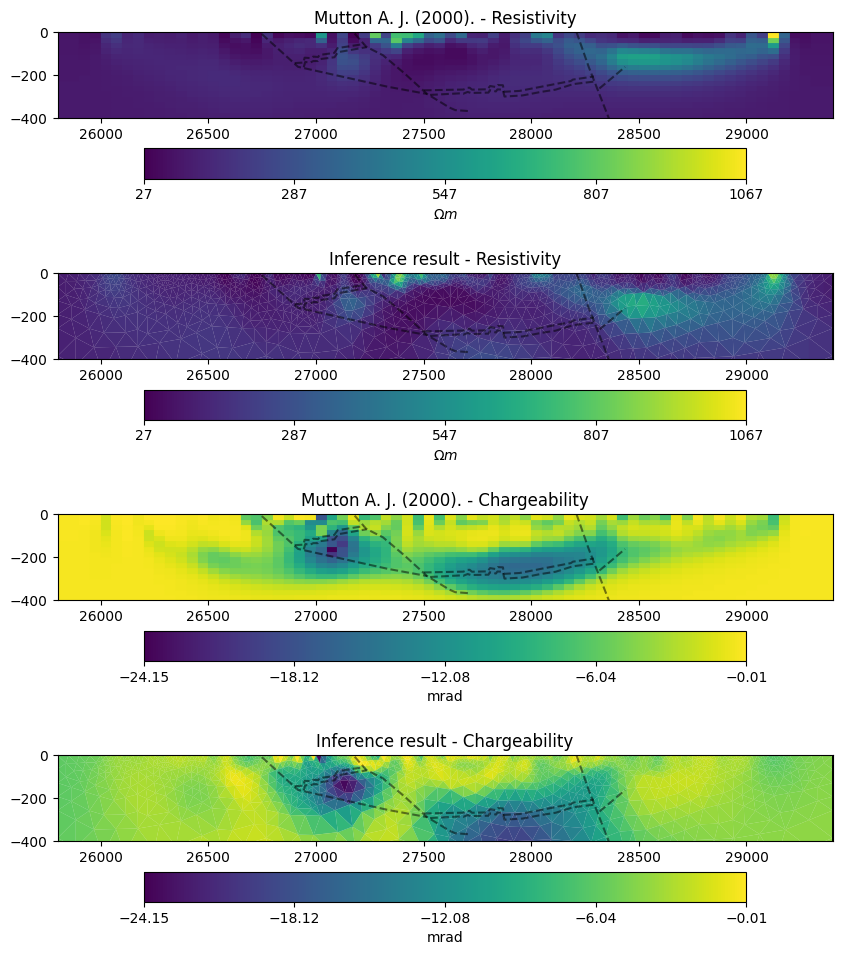

In [26]:
model_ref_dc = reference_dc_model()
model_ref_ip = reference_ip_model()
model_ref = rho_phi_to_complex(model_ref_dc, model_ref_ip)
mesh_ref_x = np.loadtxt(f"{data_base_path}/century_mesh_nodes_x.txt")
mesh_ref_z = np.loadtxt(f"{data_base_path}/century_mesh_nodes_z.txt")
mesh_ref = pygimli.meshtools.createMesh2D(mesh_ref_x, mesh_ref_z)
plot_comparison(mesh_ref, 
                model_ref, 
                "Mutton A. J. (2000).", 
                ert_mgr.paraDomain, 
                model_scipy, 
                "Inference result", 
                np.min(model_ref_dc), 
                np.max(model_ref_dc),
                np.min(model_ref_ip), 
                np.max(model_ref_ip),
               )

The use of an adaptive triangular mesh means that we use fewer model parameters when compared with the original example and that our mesh is reflective of the underlying physics. This speeds up the forward problem and in turn means that the inverse problem is less under-determined and a simpler regularisation (i.e. smoothing) in a single stage inversion is sufficient to obtain a result that compares favorably with the original solution.

In [27]:
print("Model size in the original Mutton paper:", mesh_ref.cellCount())
print("Model size of our model:", ert_mgr.paraDomain.cellCount())

Model size in the original Mutton paper: 2204
Model size of our model: 1912


---
## Watermark

In [28]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "torch", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.26.4
scipy 1.13.0
pygimli 0+untagged.4.gdb834fa
torch 2.3.0+cu121
matplotlib 3.8.3
